# 車輪型の倒立振子の制御

In [1]:
import sympy as sp

import matplotlib.pyplot as plt

from sympy.physics.mechanics import dynamicsymbols, LagrangesMethod, ReferenceFrame,Point, RigidBody, outer, Lagrangian


CuPy=False
#CuPyが使える場合はCuPyを使う
if CuPy:
    import cupy as np
    from cupyx.scipy.integrate import solve_ivp
else:
    import numpy as np
    from scipy.integrate import solve_ivp

車輪と振子のパラメータを定義

In [2]:
a,l,w=sp.symbols('a l w')
# a is the radius of the wheel
# l is the vertical distance between the wheel and pendulum
# w is the horizontal distance between the wheel and pendulum

m_p,m_w,I_p,I_w,g,mu_p,mu_w=sp.symbols('m_p m_w I_p I_w g mu_p mu_w')
# m_p is the mass of the pendulum
# m_w is the mass of the wheel
# I_p is the moment of inertia of the pendulum
# I_w is the moment of inertia of the wheel
# g is the acceleration due to gravity

theta,phi=dynamicsymbols('theta phi')
thetadot,phidot=dynamicsymbols('theta phi',1)

In [3]:
t=sp.symbols('t')
g=sp.symbols('g')

N=ReferenceFrame('N')
O=Point('O')
O.set_vel(N,0)

#振子の剛体を作成
N_p=N.orientnew('N_p','Axis',[theta,N.y])#thetaだけ回転
N_p.set_ang_vel(N,thetadot*N.y)#角速度はthetadotだけ
C_p=Point('C_p')
I_p_tensor=I_p*outer(N.y,N.y)#慣性テンソル
P=RigidBody('P',C_p,N_p,m_p,(I_p_tensor,C_p))

#車輪の剛体を作成
N_w=N_p.orientnew('N_w','Axis',[phi,N_p.y])#N_pに対してphiだけ回転
N_w.set_ang_vel(N_p,phidot*N_p.y)#角速度はphidotだけ
C_w=Point('C_w')
I_w_tensor=I_w*outer(N_w.y,N_w.y)#慣性テンソル
W=RigidBody('W',C_w,N_w,m_w,(I_w_tensor,C_w))

In [4]:
#位置の設定
C_p.set_pos(C_w,l*(sp.sin(theta)*N.x+sp.cos(theta)*N.z)+w*(sp.cos(theta)*N.x-sp.sin(theta)*N.z))
C_w.set_pos(O,a*((theta+phi)*N.x+N.z))


#速度の設定
#C_w.set_vel(N,a*(theta.diff(t,1)+phi.diff(t,1))*N.x+l*(sp.cos(theta)*theta.diff(t,1)*N.x-sp.sin(theta)*theta.diff(t,1)*N.z)+w*(-sp.sin(theta)*theta.diff(t,1)*N.x-sp.cos(theta)*theta.diff(t,1)*N.z))
C_p.set_vel(N,C_p.pos_from(O).dt(N))
C_w.set_vel(N,C_w.pos_from(O).dt(N))

In [5]:
print('kinetic energy of the pendulum')
display(P.kinetic_energy(N))

print('kinetic energy of the wheel')
display(W.kinetic_energy(N))

kinetic energy of the pendulum


I_p*Derivative(theta(t), t)**2/2 + m_p*((-l*sin(theta(t))*Derivative(theta(t), t) - w*cos(theta(t))*Derivative(theta(t), t))**2 + (a*(Derivative(phi(t), t) + Derivative(theta(t), t)) + l*cos(theta(t))*Derivative(theta(t), t) - w*sin(theta(t))*Derivative(theta(t), t))**2)/2

kinetic energy of the wheel


I_w*(Derivative(phi(t), t) + Derivative(theta(t), t))*Derivative(phi(t), t)/2 + I_w*(Derivative(phi(t), t) + Derivative(theta(t), t))*Derivative(theta(t), t)/2 + a**2*m_w*(Derivative(phi(t), t) + Derivative(theta(t), t))**2/2

In [6]:
#振子のポテンシャルエネルギー
P.potential_energy=m_p*g*(l*sp.cos(theta)-w*sp.sin(theta))
display(P.potential_energy)

g*m_p*(l*cos(theta(t)) - w*sin(theta(t)))

In [7]:
#ラグランジアン
L=Lagrangian(N,P,W)
display(L)

I_p*Derivative(theta(t), t)**2/2 + I_w*(Derivative(phi(t), t) + Derivative(theta(t), t))*Derivative(phi(t), t)/2 + I_w*(Derivative(phi(t), t) + Derivative(theta(t), t))*Derivative(theta(t), t)/2 + a**2*m_w*(Derivative(phi(t), t) + Derivative(theta(t), t))**2/2 - g*m_p*(l*cos(theta(t)) - w*sin(theta(t))) + m_p*((-l*sin(theta(t))*Derivative(theta(t), t) - w*cos(theta(t))*Derivative(theta(t), t))**2 + (a*(Derivative(phi(t), t) + Derivative(theta(t), t)) + l*cos(theta(t))*Derivative(theta(t), t) - w*sin(theta(t))*Derivative(theta(t), t))**2)/2

In [8]:
#一般化座標の設定
q=sp.Matrix([theta,phi])

In [9]:
#一般化力の設定
#制御トルク
tau=dynamicsymbols('tau')
f_control=[(N_p,-tau*N_p.y),(N_w,tau*N_w.y)]

#摩擦トルク
tau_fp,tau_fw=sp.symbols('tau_fp tau_fw')
tau_fp=mu_p*phidot
tau_fw = -mu_p * phi.diff(t, 1) - mu_w * (theta.diff(t, 1) + phi.diff(t, 1))
display(tau_fw)
f_dissipation = [(N_p, -tau_fp * N_p.y), (N_w, tau_fw * N_w.y)]

#外乱が掛かる点
P_d=Point('P_d')
P_d.set_pos(C_p,l*N_p.z+w*N_p.x)
P_d.set_vel(N,P_d.pos_from(O).dt(N))
#外乱
f_d=dynamicsymbols('f_d')
f_disturbance=[(P_d,f_d*N.x)]

f=dynamicsymbols('f')
f=f_control+f_dissipation+f_disturbance
display(f)


-mu_p*Derivative(phi(t), t) - mu_w*(Derivative(phi(t), t) + Derivative(theta(t), t))

[(N_p, - tau(t)*N_p.y),
 (N_w, tau(t)*N_w.y),
 (N_p, - mu_p*Derivative(phi(t), t)*N_p.y),
 (N_w,
  (-mu_p*Derivative(phi(t), t) - mu_w*(Derivative(phi(t), t) + Derivative(theta(t), t)))*N_w.y),
 (P_d, f_d(t)*N.x)]

In [10]:
LM=LagrangesMethod(L,q,forcelist=f,frame=N)
eom=LM.form_lagranges_equations()
display(eom)

Matrix([
[I_p*Derivative(theta(t), (t, 2)) + I_w*(Derivative(phi(t), (t, 2)) + Derivative(theta(t), (t, 2)))/2 + I_w*Derivative(phi(t), (t, 2))/2 + I_w*Derivative(theta(t), (t, 2))/2 + a**2*m_w*(2*Derivative(phi(t), (t, 2)) + 2*Derivative(theta(t), (t, 2)))/2 + g*m_p*(-l*sin(theta(t)) - w*cos(theta(t))) - l*f_d(t)*cos(theta(t)) - m_p*((-2*l*sin(theta(t))*Derivative(theta(t), t) - 2*w*cos(theta(t))*Derivative(theta(t), t))*(a*(Derivative(phi(t), t) + Derivative(theta(t), t)) + l*cos(theta(t))*Derivative(theta(t), t) - w*sin(theta(t))*Derivative(theta(t), t)) + (-l*sin(theta(t))*Derivative(theta(t), t) - w*cos(theta(t))*Derivative(theta(t), t))*(-2*l*cos(theta(t))*Derivative(theta(t), t) + 2*w*sin(theta(t))*Derivative(theta(t), t)))/2 + m_p*((-2*l*sin(theta(t)) - 2*w*cos(theta(t)))*(-l*sin(theta(t))*Derivative(theta(t), (t, 2)) - l*cos(theta(t))*Derivative(theta(t), t)**2 + w*sin(theta(t))*Derivative(theta(t), t)**2 - w*cos(theta(t))*Derivative(theta(t), (t, 2))) + (-2*l*sin(theta(t))*De

In [11]:
#状態方程式
state_eqs=LM.rhs()
display(state_eqs)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [12]:
class Param:
    def __init__(self):
        self.a=0.15
        self.l=0.50
        self.w=0.05
        self.m_p=1.5
        self.m_w=0.3
        self.I_p=self.m_p*self.m_p*self.l**2/3
        self.I_w=self.m_w*self.m_w*self.a**2/2
        self.g=9.8
        self.mu_p=0.5
        self.mu_w=0.05


In [13]:
#数値計算用のパラメータ
par=Param()

k_p=0.5
k_d=0.5

otheta=np.arctan(par.w/par.l)


In [14]:
#線形化
#動作点の設定
op_point={theta:-otheta,thetadot:0,phi:0,phidot:0}

#線形化
kwargs = {'q_ind': [theta, phi], 'qd_ind': [thetadot, phidot],'A_and_B': True, 'op_point': op_point, 'simplify': True}
A, B, inp_vec = LM.linearize(**kwargs)

In [15]:
display(A)
display(B)
display(inp_vec)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

Matrix([
[f_d(t)],
[tau(t)]])

In [23]:
#f_d_funcの定義
def f_d_func(t):
    return 0

#tau_funcの定義
def tau_func(t,y):
    return k_p*(y[0]-otheta)+k_d*y[2]+10*y[1]

In [24]:
#numpy形式の関数に変換
f_np=state_eqs.subs([(a,par.a),(l,par.l),(w,par.w),(m_p,par.m_p),(m_w,par.m_w),(I_p,par.I_p),(I_w,par.I_w),(g,par.g),(mu_p,par.mu_p),(mu_w,par.mu_w)])
#display(f_np)
f_np_nu=sp.lambdify([thetadot,phidot,theta,phi,f_d,tau],f_np,'numpy')

#numpy形式の関数に変換
def f_np_func(t,y):
    ret=f_np_nu(y[2],y[3],y[0],y[1],f_d_func(t),tau_func(t,y))
    return ret.flatten()
    #fn_np_temp=f_np.subs([(thetadot,y[2]),(phidot,y[3]),(theta,y[0]),(phi,y[1]),(f_d,f_d_func(t)),(tau,tau_func(t,y))])
    #return [fn_np_temp[0],fn_np_temp[1],fn_np_temp[2],fn_np_temp[3]]

#odeintで数値計算
#初期値
y0=[0,0,0.1,0.1]

t=np.linspace(0,10,100)
y=odeint(f_np_func,t,y0)



In [25]:

#solve_ivp
k_p=10
k_d=10

t_span=[0,10]
y0=[-otheta,0.0,0.0,0]
t_eval = np.linspace(*t_span,100)
sol=solve_ivp(f_np_func,t_span,y0,method='RK45',t_eval=t_eval)


In [26]:
y=sol.y.T
np.shape(y)

(100, 4)

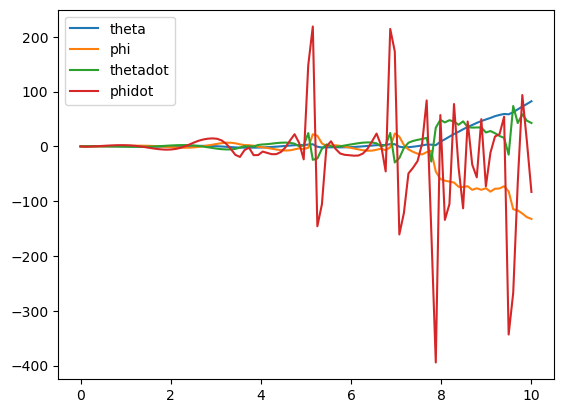

In [27]:
#4つの値を重ねてプロット
fig,ax=plt.subplots()
ax.plot(t_eval,sol.y[0])
ax.plot(t_eval,sol.y[1])
ax.plot(t_eval,sol.y[2])
ax.plot(t_eval,sol.y[3])
#凡例を追加
plt.legend(['theta','phi','thetadot','phidot'])
plt.show()


# アニメーションの作成

In [28]:
import matplotlib.animation as animation


In [29]:
#データの整理
y[:,0]=sol.y[0]
y[:,1]=sol.y[1]
y[:,2]=sol.y[2]
y[:,3]=sol.y[3]

x_w=par.a*(y[:,0]+y[:,1])#車輪のx座標
atheta=y[:,0]#振子の角度
aphi=y[:,1]#車輪の角度

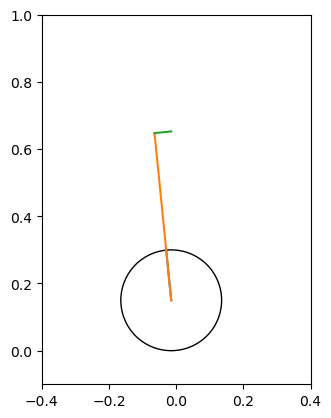

In [30]:
#車輪の描写
#半径par.aの円を描写
#座標は(x_w,par.a)
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(-0.4, 0.4)
ax.set_ylim(-0.1, 1)
circle = plt.Circle((x_w[0], par.a), par.a, fill=False)
ax.add_artist(circle)
#車輪にしるしをつける
line_w, = ax.plot([x_w[0], par.a], [x_w[0], 2*par.a])

#振子の描写
#振子の先端の座標は(x_w,par.a)
#振子の中心の座標は(x_w+par.l*np.sin(atheta),par.a-par.l*np.cos(atheta))
line, = ax.plot([x_w[0], x_w[0]+par.l*np.sin(atheta[0])], [par.a, par.a+par.l*np.cos(atheta[0])])
line2,= ax.plot([x_w[0]+par.l*np.sin(atheta[0]),x_w[0]+par.l*np.sin(atheta[0])+par.w*np.cos(atheta[0])], [par.a+par.l*np.cos(atheta[0]),par.a+par.l*np.cos(atheta[0])-par.w*np.sin(atheta[0])])

#アニメーションの関数
def update(num):
    #車輪を動かす
    circle.center = (x_w[num], par.a)
    line_w.set_xdata([x_w[num], x_w[num]+par.a*np.sin(atheta[num]+aphi[num])])
    line_w.set_ydata([par.a, par.a*(1+np.cos(atheta[num]+aphi[num]))])
    #振子を動かす
    line.set_xdata([x_w[num], x_w[num]+par.l*np.sin(atheta[num])])
    line.set_ydata([par.a, par.a+par.l*np.cos(atheta[num])])
    line2.set_xdata([x_w[num]+par.l*np.sin(atheta[num]),x_w[num]+par.l*np.sin(atheta[num])+par.w*np.cos(atheta[num])])
    line2.set_ydata([par.a+par.l*np.cos(atheta[num]),par.a+par.l*np.cos(atheta[num])-par.w*np.sin(atheta[num])])

    return line , circle,line_w,line2

ani = animation.FuncAnimation(fig, update, frames = len(t_eval), interval = (t_eval[1] - t_eval[0]) * 20 * 1000, blit = True)
plt.show()
ani.save('pendulum_wheel.gif', writer='pillow', fps=5)
